In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting

reload(misc)
reload(plotting)

first_year = 1990

data_dir = '.'
data_file = os.path.join(data_dir, 'ssm_with_metadata_2017_03_13.csv')

data = misc.read_tone_data(data_file, first_year)

last_date = data['date'].max()

print "Loaded data for %d articles" % len(data.index)

Loaded data for 7825 articles


Grouped data into 92 periods


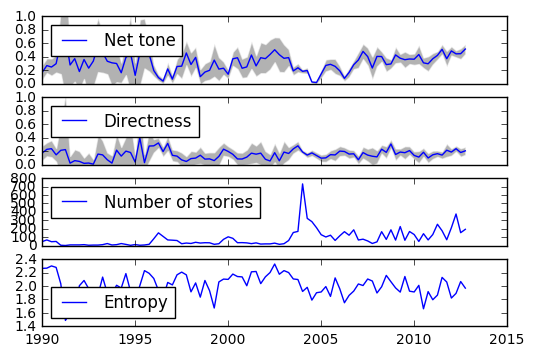

In [29]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_tone_data(data, group_by)

print "Grouped data into %d periods" % len(grouped.index)

plotting.plot_variables(grouped)

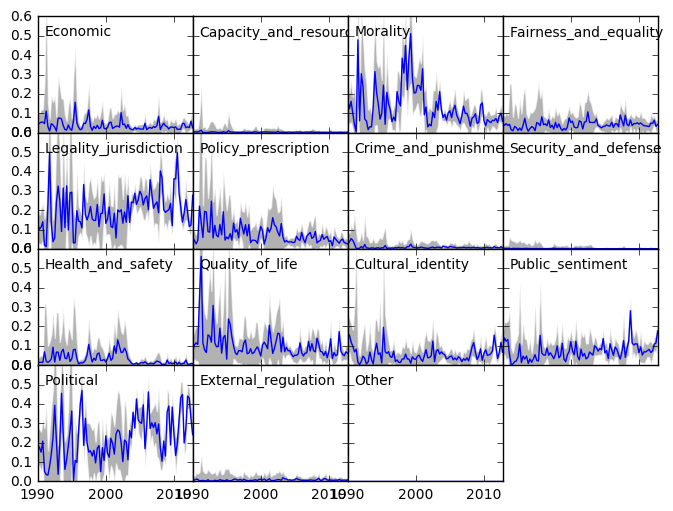

In [3]:
reload(plotting)

plotting.plot_frames(grouped)

In [30]:
reload(misc)

filename = 'samesex_marriage_polls.csv'

# subcode 151 = gay marriage
polls = misc.load_polls(filename, first_year, last_date, subcode=151)

print "Loaded %d polls" % len(polls.index)
print polls.shape

Loaded 170 polls
(170, 28)


(0, 1)

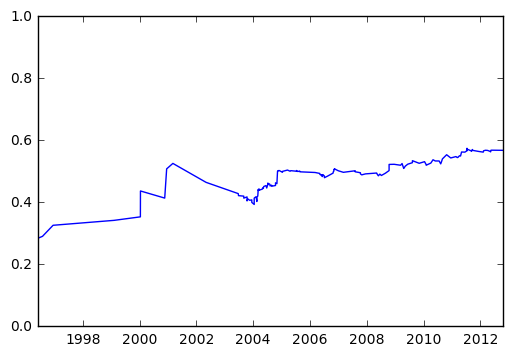

In [31]:
# calculate an exponentially-weighted running average for all polls and plot it

reload(misc)

running_average = misc.calculate_weighted_average(polls, temperature=500)
polls['running_average'] = running_average

plt.plot(polls['date'], polls['running_average']/100.0)
plt.ylim(0, 1)

In [7]:
reload(misc)

combined = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30)
#combined = misc.combine_polls_and_tone(polls, grouped)

print combined.describe()

              Pro     Neutral        Anti  directness     stories     entropy  \
count  170.000000  170.000000  170.000000  170.000000  170.000000  170.000000   
mean     0.522506    0.205779    0.271715    0.181919   89.370588    1.882826   
std      0.078904    0.028607    0.072951    0.068911  100.219984    0.160974   
min      0.351622    0.113078    0.141187    0.019199    4.000000    1.460610   
25%      0.469704    0.191638    0.209614    0.141189   29.500000    1.787535   
50%      0.523983    0.207724    0.267403    0.171014   57.500000    1.871207   
75%      0.590360    0.221701    0.314519    0.213475   95.750000    2.006750   
max      0.709046    0.294368    0.434143    0.385024  461.000000    2.241644   

             tone       Value           N  running_average     ...      \
count  170.000000  170.000000  170.000000       169.000000     ...       
mean     0.250791    0.508277    0.102636         0.483945     ...       
std      0.149255    0.116684    0.081424       

/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Question	Responses
  GAYWED	43
GAYMARNY	33
 HOMOMAR	19
GAYWEDPSR	15
GAYWEDABC	11
 PSGAYUN	9
   ABCCU	9
GAYWEDFOX	8
  ABCBAN	7
 GAYJOBS	6
 MARHOMO	3
  GAYMAR	2
  BANMAR	2
GAYAMEND	2
CIVUNION	1


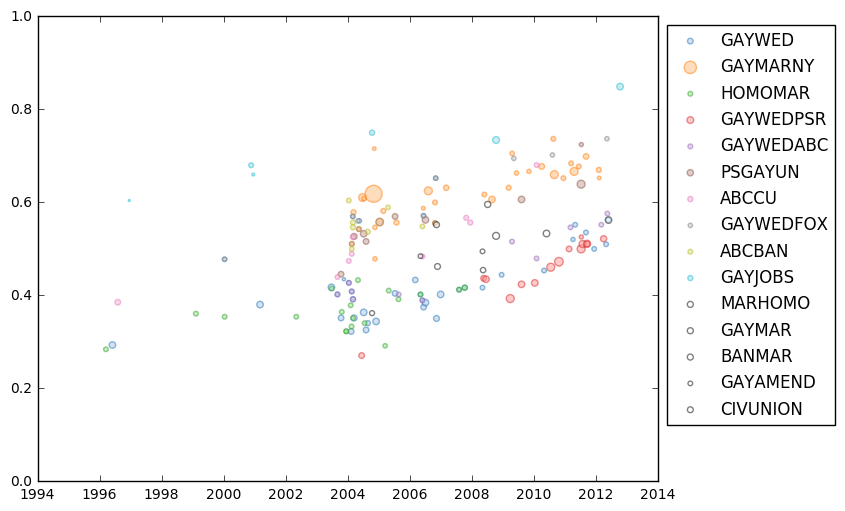

In [8]:
reload(plotting)

plotting.plot_polling_data(combined)


In [9]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 50), axis=1)

# add in interactions
# between tone and number of stories per quarter

#grouped['stories'] = np.log(grouped['stories'])


combined['toneXstories'] = combined['tone'] * combined['stories']
combined['directnessXstories'] = combined['directness'] * combined['stories']

combined['proXstories'] = combined['Pro'] * combined['stories']
combined['antiXstories'] = combined['Anti'] * combined['stories']
combined['neutralXstories'] = combined['Neutral'] * combined['stories']

combined['entropyXstories'] = combined['entropy'] * combined['stories']
combined['entropyXtone'] =  combined['entropy'] * combined['tone']
combined['entropyXtoneXstories'] =  combined['entropy'] * combined['tone'] * combined['stories']

combined['toneXdirectness'] = combined['tone'] * combined['directness']
combined['toneXdirectnessXstories'] = combined['tone'] * combined['directness'] * combined['stories']

combined['toneXsalient'] = combined['tone'] * combined['salient']
combined['directnessXsalient'] = combined['directness'] * combined['salient']

#for year in range(1990,2014):
#    combined['post_' + str(year)] = [int(combined.index[i][0] > year) for i in range(len(combined.index))]    
    
#combined['post_event_1990'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1991) for i in range(len(combined.index))]
#combined['post_event_1994'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1995) for i in range(len(combined.index))]
#combined['post_event_2000'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2000.5) for i in range(len(combined.index))]
#combined['post_event_2001'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2002) for i in range(len(combined.index))]
#combined['post_event_2006'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2006.5) for i in range(len(combined.index))]


In [10]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <GAYWED> + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR>
             + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX> + <ABCBAN>
             + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   16

R-squared:         0.7110
Adj R-squared:     0.6828

Rmse:              0.0209

F-stat (15, 154):    25.2580, p-value:     0.0000

Degrees of Freedom: model 15, resid 154

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories     0.0007     0.0001       9.73     0.0000     0.0005     0.0008
        GAYWED    -0.0327     0.0212      -1.54     0.1250    -0.0741     0.0088
      GAYMARNY     0.1648    

In [11]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <toneXstories> + <GAYWED> + <GAYMARNY>
             + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX>
             + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR>
             + <GAYAMEND> + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   17

R-squared:         0.8164
Adj R-squared:     0.7971

Rmse:              0.0166

F-stat (16, 152):    42.2553, p-value:     0.0000

Degrees of Freedom: model 16, resid 152

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.8090     0.0258      31.30     0.0000     0.7583     0.8597
  toneXstories     0.0004     0.0001       6.89     0.0000     0.0003     0.

In [12]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <GAYWED> + <GAYMARNY> + <HOMOMAR>
             + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX> + <ABCBAN>
             + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   17

R-squared:         0.7607
Adj R-squared:     0.7356

Rmse:              0.0191

F-stat (16, 153):    30.3925, p-value:     0.0000

Degrees of Freedom: model 16, resid 153

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2195     0.0110      19.93     0.0000     0.1979     0.2411
       stories     0.0000     0.0000       0.69     0.4924    -0.0000     0.0000
        GAYWED    -0.0340

In [13]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <GAYWED> + <GAYMARNY>
             + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU>
             + <GAYWEDFOX> + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR>
             + <GAYAMEND> + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   18

R-squared:         0.8202
Adj R-squared:     0.8000

Rmse:              0.0165

F-stat (17, 151):    40.5199, p-value:     0.0000

Degrees of Freedom: model 17, resid 151

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.7129     0.0288      24.74     0.0000     0.6565     0.7694
          tone     0.0926     0.0107       8.68     0.0000     0.0717   

In [14]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <GAYWED> + <GAYMARNY>
             + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX>
             + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR>
             + <GAYAMEND> + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   18

R-squared:         0.7687
Adj R-squared:     0.7428

Rmse:              0.0188

F-stat (17, 152):    29.7075, p-value:     0.0000

Degrees of Freedom: model 17, resid 152

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.1313     0.0165       7.97     0.0000     0.0990     0.1636
       stories    -0.0002     0.0000      -6.42     0.0000    -0.0003    -0.

In [15]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <GAYWED>
             + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN>
             + <ABCCU> + <GAYWEDFOX> + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR>
             + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   19

R-squared:         0.8227
Adj R-squared:     0.8014

Rmse:              0.0165

F-stat (18, 150):    38.6613, p-value:     0.0000

Degrees of Freedom: model 18, resid 150

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.6879     0.0292      23.57     0.0000     0.6307     0.7451
          tone     0.0474     0.0147       3.22     0.0

In [16]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <GAYWED> + <GAYMARNY> + <HOMOMAR>
             + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX>
             + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR> + <BANMAR> + <GAYAMEND>
             + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   18

R-squared:         0.7727
Adj R-squared:     0.7473

Rmse:              0.0187

F-stat (17, 152):    30.3963, p-value:     0.0000

Degrees of Freedom: model 17, resid 152

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2459     0.0112      21.95     0.0000     0.2239     0.2678
       stories    -0.0000     0.0000      -0.76     0.4479    -0.0000     0.0000


In [17]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <GAYWED>
             + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN>
             + <ABCCU> + <GAYWEDFOX> + <ABCBAN> + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   14

R-squared:         0.7110
Adj R-squared:     0.6867

Rmse:              0.0207

F-stat (13, 155):    29.3276, p-value:     0.0000

Degrees of Freedom: model 13, resid 155

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.6776     0.0376      18.03     0.0000     0.6039     0.7512
          tone     0.0833     0.0141       5.92     0.0000     0.0557     0.1108
       stories     0.0000     0.0000       0.46    

In [18]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <entropy> + <entropyXtone>
             + <GAYWED> + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC>
             + <PSGAYUN> + <ABCCU> + <GAYWEDFOX> + <ABCBAN> + <GAYJOBS> + <MARHOMO>
             + <GAYMAR> + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   20

R-squared:         0.7787
Adj R-squared:     0.7507

Rmse:              0.0186

F-stat (19, 150):    27.7800, p-value:     0.0000

Degrees of Freedom: model 19, resid 150

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2597     0.1182       2.20     0.0296     0.0279     0.4914
       stories    -0.0002     0.0000      -5.86

In [19]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'stories', 'tone', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <stories> + <tone> + <toneXstories> + <entropy>
             + <entropyXtone> + <GAYWED> + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR>
             + <GAYWEDABC> + <PSGAYUN> + <ABCCU> + <GAYWEDFOX> + <ABCBAN>
             + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   16

R-squared:         0.7121
Adj R-squared:     0.6839

Rmse:              0.0208

F-stat (15, 153):    25.2327, p-value:     0.0000

Degrees of Freedom: model 15, resid 153

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.6640     0.0383      17.32     0.0000     0.5889     0.7391
       stories    -0.0001     0.0000      -1.86     0.0652    -0.0002     0.0000
    

In [20]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['tone', 'stories', 'toneXstories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <entropy> + <GAYWED>
             + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC> + <PSGAYUN> + <ABCCU>
             + <GAYWEDFOX> + <ABCBAN> + <GAYJOBS> + <MARHOMO> + <GAYMAR>
             + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         170
Number of Degrees of Freedom:   19

R-squared:         0.7786
Adj R-squared:     0.7522

Rmse:              0.0185

F-stat (18, 151):    29.5045, p-value:     0.0000

Degrees of Freedom: model 18, resid 151

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.1673     0.0169       9.91     0.0000     0.1342     0.2003
       stories    -0.0002     0.0000      -6.19     0.0000    -0

In [27]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <entropy>
             + <GAYWED> + <GAYMARNY> + <HOMOMAR> + <GAYWEDPSR> + <GAYWEDABC>
             + <PSGAYUN> + <ABCCU> + <GAYWEDFOX> + <ABCBAN> + <GAYJOBS> + <MARHOMO>
             + <GAYMAR> + <BANMAR> + <GAYAMEND> + <intercept>

Number of Observations:         169
Number of Degrees of Freedom:   20

R-squared:         0.8237
Adj R-squared:     0.8013

Rmse:              0.0165

F-stat (19, 149):    36.6489, p-value:     0.0000

Degrees of Freedom: model 19, resid 149

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.6601     0.0305      21.67     0.0000     0.6004     0.7198
          tone     0.0630     0.0157       